# DiploDatos 2019 - Análisis de Series Temporales

## Integrantes

| Nombre | e-mail |
|------|------|
|Rivadero, Isabel | isarivadero@hotmail.com |
|Vargas, Miguel | lvc0107@protonmail.com |
|Mancuso, Fernando | manquius@gmail.com |

## Práctico de Análisis y Curación de datos

En este práctico  continuaremos analizando el dataset más en detalle y tomaremos
acciones de limpieza y curación sobre los datos cuando sea necesario

In [1]:
### Aumentar el ancho del notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Dataset

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(rc={'figure.figsize':(10,6)})

cols = ['service',
        'sender_zipcode',
        'receiver_zipcode',
        'sender_state',
        'receiver_state',
        'shipment_type',
        'quantity',
        'status',
        'date_created',
        'date_sent',
        'date_visit',
        'target']
cols_holidays = ['holiday', 
                 'description']
data_path = './shipments_BR_201903.csv'
holidays = './holidays.csv'

#### Referencia de las columnas
* **service**: Identificador unico que corresponde a un tipo de servicio de un correo en particular.
* **sender_zipcode:** Código postal de quien envía el paquete (usualmente el vendedor).
* **receiver_zipcode:** Código postal de quien recibe el paquete (usualmente el comprador).
* **sender_state:** Nombre abreviado del estado de quien envía el paquete.
* **receiver_state:** Nombre abreviado del estado de quien recibe el paquete.
* **quantity:** Cantidad de items que tiene dentro el paquete.
* **status:** Estado final del envío.
* **date_created:** Fecha de compra de el o los items.
* **date_sent:** Fecha en que el correo recibe el paquete.
* **date_visit:** Fecha en que el correo entrega el paquete.
* **target:** Cantidad de dias hábiles que tardó el correo en entregar el paquete desde que lo recibe.


In [3]:
df = pd.read_csv(data_path, usecols=cols)
df.shape

(1000000, 12)

In [4]:
df.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
0,SP,3005,SP,5409,express,1,0,done,2019-03-04 00:00:00,2019-03-05 13:24:00,2019-03-07 18:01:00,2
1,SP,17052,MG,37750,standard,1,1,done,2019-03-19 00:00:00,2019-03-20 14:44:00,2019-03-27 10:21:00,5
2,SP,2033,SP,11040,express,1,0,done,2019-02-18 00:00:00,2019-02-21 15:08:00,2019-02-28 18:19:00,5
3,SP,13900,SP,18500,express,1,0,done,2019-03-09 00:00:00,2019-03-11 15:48:00,2019-03-12 13:33:00,1
4,SP,4361,RS,96810,express,1,0,done,2019-03-08 00:00:00,2019-03-12 08:19:00,2019-03-16 08:24:00,4


In [5]:
# set seed for reproducibility
np.random.seed(0)

In [6]:
df.sample(5)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
157105,SP,14405,MG,37706,standard,2,3,done,2019-03-13 00:00:00,2019-03-19 20:52:00,2019-03-22 11:00:00,3
374554,BA,40260,SE,49088,standard,1,1,done,2019-03-04 00:00:00,2019-03-06 15:32:00,2019-03-23 11:23:00,12
688694,SP,8061,DF,70236,express,1,0,done,2019-03-15 00:00:00,2019-03-15 16:04:00,2019-03-18 12:00:00,1
265381,SP,3118,BA,48455,standard,3,1,done,2019-03-10 00:00:00,2019-03-11 14:58:00,2019-03-27 07:56:00,12
955415,SP,14402,DF,71503,standard,1,4,done,2019-03-01 00:00:00,2019-03-07 03:55:36,2019-03-11 16:39:00,1


In [7]:
df.dtypes

sender_state        object
sender_zipcode       int64
receiver_state      object
receiver_zipcode     int64
shipment_type       object
quantity             int64
service              int64
status              object
date_created        object
date_sent           object
date_visit          object
target               int64
dtype: object

In [8]:
df.describe()

,sender_zipcode,receiver_zipcode,quantity,service,target
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,22637.975896,41650.306365,1.277814,1.182677,6.021577
std,27817.028435,30952.352631,0.661583,1.486557,5.157973
min,1001.000000,1001.000000,1.000000,0.000000,0.000000
25%,4836.000000,13465.000000,1.000000,0.000000,2.000000
50%,12091.000000,35164.000000,1.000000,1.000000,4.000000
75%,23050.000000,72308.000000,1.000000,1.000000,9.000000
max,99990.000000,99990.000000,5.000000,11.000000,118.000000


**Implementación
Como primer paso es necesario verificar la consistencia de la información.
Para esto debemos verificar al menos lo siguiente:**

1- ¿Los ids son únicos?

In [9]:
df.index

RangeIndex(start=0, stop=1000000, step=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
sender_state        1000000 non-null object
sender_zipcode      1000000 non-null int64
receiver_state      1000000 non-null object
receiver_zipcode    1000000 non-null int64
shipment_type       1000000 non-null object
quantity            1000000 non-null int64
service             1000000 non-null int64
status              1000000 non-null object
date_created        1000000 non-null object
date_sent           1000000 non-null object
date_visit          1000000 non-null object
target              1000000 non-null int64
dtypes: int64(5), object(7)
memory usage: 91.6+ MB


Pandas asigna un rango de indices por default automaticamente, en este caso (RangeIndex: 1000000 entries, 0 to 999999), que nos permite identificar cada envío de paquetes. Sin embargo, si deseamos indexar rows en el dataframe por algun valor de las columnas debemos construir un nuevo index de manera de identificar facilmente los envíos de paquetes

Ejemplo si deseamos acceder al envío en la posición 24 del dataframe:

In [11]:
df.loc[24]

sender_state                         SP
sender_zipcode                     5616
receiver_state                       SP
receiver_zipcode                  17220
shipment_type                   express
quantity                              1
service                               0
status                             done
date_created        2019-02-27 00:00:00
date_sent           2019-03-01 15:18:00
date_visit          2019-03-02 10:39:00
target                                1
Name: 24, dtype: object

2- Si no tuviéramos estos índices, ¿tenemos información para construir una clave
primaria?

Si. Sabemos que contamos con 11 servicios. 
Si un servicio envía un paquete i desde una region X en una fecha dada a una region Y, y el mismo servicio envía un paquete j en la misma fecha desde la misma region X al mismo destino Y, podemos concluir que en realidad el paquete i es igual al paquete j.

Podemos expresar esto como:

servicio + origen + destino + fecha de envío = identificador único de un envío.

Las fechas por si solas parecen ser únicas, pero podemos suponer que en un futuro el sistema de envíos pueda permitar enviar multiples paquetes de forma paralela en el mismo horario. Es por esto que fortalecemos la clave con datos de la ruta(sender_zipcode - receiver_zipcode).

Por lo tanto la ruta (origen + destino) mas una fecha dada puede utilizarse como identificador único para cada envío.
Como mencionamos inicialmente existen 11 servicios. Fortalecemos tambien la clave incorporando el identificador de servicio, pues puede darse el escenario de que dos servicios en la misma region, envíen paquetes a la misma hora y al mismo destino. (Es poco probable, pero no imposible).
Por otro lado sabemos que el dataframe contiene 1000000 de filas, por lo tanto debemos comprobar si esta cantidad coincide con la 
propuesta para los ids.


In [12]:
df.loc[:, ['service', 'date_sent', 'sender_zipcode', 'receiver_zipcode']].shape

(1000000, 4)

Se puede establecer el index para cada fila de la siguiente manera:

In [13]:
keys = ['service', 'date_sent', 'sender_zipcode', 'receiver_zipcode']

df1 = df.set_index(keys, drop=True, append=False, inplace=False, verify_integrity=False)
df1.head()

sender_state  \
service date_sent           sender_zipcode receiver_zipcode                
0       2019-03-05 13:24:00 3005           5409                       SP   
1       2019-03-20 14:44:00 17052          37750                      SP   
0       2019-02-21 15:08:00 2033           11040                      SP   
        2019-03-11 15:48:00 13900          18500                      SP   
        2019-03-12 08:19:00 4361           96810                      SP   

                                                            receiver_state  \
service date_sent           sender_zipcode receiver_zipcode                  
0       2019-03-05 13:24:00 3005           5409                         SP   
1       2019-03-20 14:44:00 17052          37750                        MG   
0       2019-02-21 15:08:00 2033           11040                        SP   
        2019-03-11 15:48:00 13900          18500                        SP   
        2019-03-12 08:19:00 4361           96810                        RS   

                                                            shipment_type  \
service date_sent           sender_zipcode receiver_zipcode                 
0       2019-03-05 13:24:00 3005           5409                   express   
1       2019-03-20 14:44:00 17052          37750                 standard   
0       2019-02-21 15:08:00 2033           11040                  express   
        2019-03-11 15:48:00 13900          18500                  express   
        2019-03-12 08:19:00 4361           96810                  express   

                                                             quantity status  \
service date_sent           sender_zipcode receiver_zipcode                    
0       2019-03-05 13:24:00 3005           5409                     1   done   
1       2019-03-20 14:44:00 17052          37750                    1   done   
0       2019-02-21 15:08:00 2033           11040                    1   done   
        2019-03-11 15:48:00 13900          18500                    1   done   
        2019-03-12 08:19:00 4361           96810                    1   done   

                                                                    date_created  \
service date_sent           sender_zipcode receiver_zipcode                        
0       2019-03-05 13:24:00 3005           5409              2019-03-04 00:00:00   
1       2019-03-20 14:44:00 17052          37750             2019-03-19 00:00:00   
0       2019-02-21 15:08:00 2033           11040             2019-02-18 00:00:00   
        2019-03-11 15:48:00 13900          18500             2019-03-09 00:00:00   
        2019-03-12 08:19:00 4361           96810             2019-03-08 00:00:00   

                                                                      date_visit  \
service date_sent           sender_zipcode receiver_zipcode                        
0       2019-03-05 13:24:00 3005           5409              2019-03-07 18:01:00   
1       2019-03-20 14:44:00 17052          37750             2019-03-27 10:21:00   
0       2019-02-21 15:08:00 2033           11040             2019-02-28 18:19:00   
        2019-03-11 15:48:00 13900          18500             2019-03-12 13:33:00   
        2019-03-12 08:19:00 4361           96810             2019-03-16 08:24:00   

                                                             target  
service date_sent           sender_zipcode receiver_zipcode          
0       2019-03-05 13:24:00 3005           5409                   2  
1       2019-03-20 14:44:00 17052          37750                  5  
0       2019-02-21 15:08:00 2033           11040                  5  
        2019-03-11 15:48:00 13900          18500                  1  
        2019-03-12 08:19:00 4361           96810                  4

Ejemplo, si deseamos obtener el envío realizado por el servicio 0 el dia 2019-02-21 15:08:00 y enviado desde la region con zipcode 2033 a la region con zip code 11040 se puede ejecutar el siguiente filtro:

In [14]:
df1.loc[(0, '2019-02-21 15:08:00', 2033, 11040)]

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


,,,,sender_state,receiver_state,shipment_type,quantity,status,date_created,date_visit,target
service,date_sent,sender_zipcode,receiver_zipcode,,,,,,,,
0,2019-02-21 15:08:00,2033,11040,SP,SP,express,1,done,2019-02-18 00:00:00,2019-02-28 18:19:00,5


Tambien se puede obtener un subgrupo de envíos que se ajusten a un subconjunto de los atributos del indice, por ejemplo obtener todos los envíos reaizados por el servicio 0 en la fecha 2019-02-21 15:08:00, sin especificar la ruta

In [15]:
df1.loc[(0, '2019-02-21 15:08:00')]

/Users/luisvargas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


,,sender_state,receiver_state,shipment_type,quantity,status,date_created,date_visit,target
sender_zipcode,receiver_zipcode,,,,,,,,
2033,11040,SP,SP,express,1,done,2019-02-18 00:00:00,2019-02-28 18:19:00,5
22430,9771,RJ,SP,express,2,done,2019-02-21 00:00:00,2019-03-04 21:01:00,7


En este caso el resultado no devuelve los valores del indice.

Observar que el orden de los componentes del indice deben respetarse, caso contrario se lanza una  excepción 'KeyError'

3- ¿Tenemos datos faltantes? Dar detalles.

In [17]:
# get the number of missing data points per column
missing_values_count = df.isnull().sum()
missing_values_count

sender_state        0
sender_zipcode      0
receiver_state      0
receiver_zipcode    0
shipment_type       0
quantity            0
service             0
status              0
date_created        0
date_sent           0
date_visit          0
target              0
dtype: int64

No hay valores faltantes

4- ¿Tenemos datos inconsistentes o raros? Dar detalles.

Hay que realizar un análisis por cada uno de los features. Basicamente tenemos que ver que los datos de cada feature pertenecen a su dominio.
En una segunda etapa hay que analizar que los datos de cada feature en un envío son coherentes.

Estados: analizamos si existe algún valor inusual:

In [18]:
np.sort(df["sender_state"].unique())

array(['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG',
       'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR',
       'RS', 'SC', 'SE', 'SP', 'TO'], dtype=object)

In [19]:
np.sort(df["receiver_state"].unique())

array(['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG',
       'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR',
       'RS', 'SC', 'SE', 'SP', 'TO'], dtype=object)

Analizamos los datos de tipo datetime:

In [20]:
df[df["date_sent"] > df["date_visit"]]

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
227160,SP,13920,DF,70857,standard,1,1,done,2019-03-22 00:00:00,2019-03-26 15:56:00,2019-03-26 08:10:00,0
597454,SP,9961,PE,55604,standard,1,4,done,2019-02-28 00:00:00,2019-03-04 21:58:09,2019-03-04 17:21:00,0


Hay dos filas con fechas inconcistentes. Es improbable que en Brasil hayan mas de cuatro franjas horarias que justifiquen estos datos.

In [21]:
df1 = df[df["date_created"] > df["date_sent"]]
df1.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
8622,SP,1521,DF,72504,standard,1,7,done,2019-06-27 00:00:00,2019-02-06 10:41:00,2019-03-06 14:18:00,17
10681,SP,3822,PE,51200,standard,1,4,sent,2019-06-18 00:00:00,2019-03-06 13:00:00,2019-03-06 13:24:00,0
13241,SP,14405,DF,71699,standard,1,7,done,2019-06-20 00:00:00,2019-03-06 05:17:00,2019-03-06 13:17:00,0
13295,SP,15820,MS,79011,express,1,7,done,2019-06-18 00:00:00,2019-02-06 11:34:00,2019-03-06 13:28:00,17
13446,SP,9961,SP,18125,standard,1,4,sent,2019-06-28 00:00:00,2019-02-06 03:43:00,2019-03-06 10:49:00,17


In [22]:
len(df1)

171

Mas datos inconcistentes. Hay 171 compras que se realizaron despues de que fueron enviadas.

In [23]:
df2 = df[df["date_created"] > df["date_visit"]]
df2.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
8622,SP,1521,DF,72504,standard,1,7,done,2019-06-27 00:00:00,2019-02-06 10:41:00,2019-03-06 14:18:00,17
10681,SP,3822,PE,51200,standard,1,4,sent,2019-06-18 00:00:00,2019-03-06 13:00:00,2019-03-06 13:24:00,0
13241,SP,14405,DF,71699,standard,1,7,done,2019-06-20 00:00:00,2019-03-06 05:17:00,2019-03-06 13:17:00,0
13295,SP,15820,MS,79011,express,1,7,done,2019-06-18 00:00:00,2019-02-06 11:34:00,2019-03-06 13:28:00,17
13446,SP,9961,SP,18125,standard,1,4,sent,2019-06-28 00:00:00,2019-02-06 03:43:00,2019-03-06 10:49:00,17


In [24]:
len(df2)

168

Mas datos inconcistentes. Hay 168 compras que se realizaron despues de que fueron entregadas.

Analizamos todas las fechas para un envío:


In [25]:
len(df[(df['date_sent'] > df['date_visit']) | (df['date_created'] > df['date_sent']) | (df['date_created'] > df['date_visit'])])

173

En total 173 filas tienen datos inconcistentes con respecto a las fechas. Dados que es una cantidad baja de datos inconcistentes 173/1000000, se pueden eliminar del dataframe

In [26]:
df1 = df[(df['date_sent'] <= df['date_visit']) & (df['date_created'] <= df['date_sent']) & (df['date_created'] <= df['date_visit'])].copy()

In [27]:
df1.shape

(999827, 12)

Para los zip codes podemos en primer lugar verificar si son todos de tipo numérico:

In [28]:
df1 = df[['sender_zipcode','receiver_zipcode']].copy()
df1.head()

,sender_zipcode,receiver_zipcode
0,3005,5409
1,17052,37750
2,2033,11040
3,13900,18500
4,4361,96810


In [29]:
df1[df1['sender_zipcode'].apply(lambda x: isinstance(x, int))].shape


(1000000, 2)

In [30]:
df1[df1['receiver_zipcode'].apply(lambda x: isinstance(x, int))].shape


(1000000, 2)

Se puede tambien verificar que los zip code esten en un rango correcto de sus valores(min y max).

In [31]:
df1.describe()

,sender_zipcode,receiver_zipcode
count,1000000.000000,1000000.000000
mean,22637.975896,41650.306365
std,27817.028435,30952.352631
min,1001.000000,1001.000000
25%,4836.000000,13465.000000
50%,12091.000000,35164.000000
75%,23050.000000,72308.000000
max,99990.000000,99990.000000


También se puede analizar si ademas de que los valores esten en su rango correcto de valores, que estos sean correctos.
Es decir, que no hayan zip codes entre 1001-99990 con valores invalidos.


5-¿Tenemos outliers muy lejanos? ¿Conviene quitarlos del dataset?

{'whiskers': [<matplotlib.lines.Line2D at 0x1a236c7978>,
 'caps': [<matplotlib.lines.Line2D at 0x1a236c7e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a236c7518>],
 'medians': [<matplotlib.lines.Line2D at 0x1a236b17b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a236b1b38>],
 'means': []}

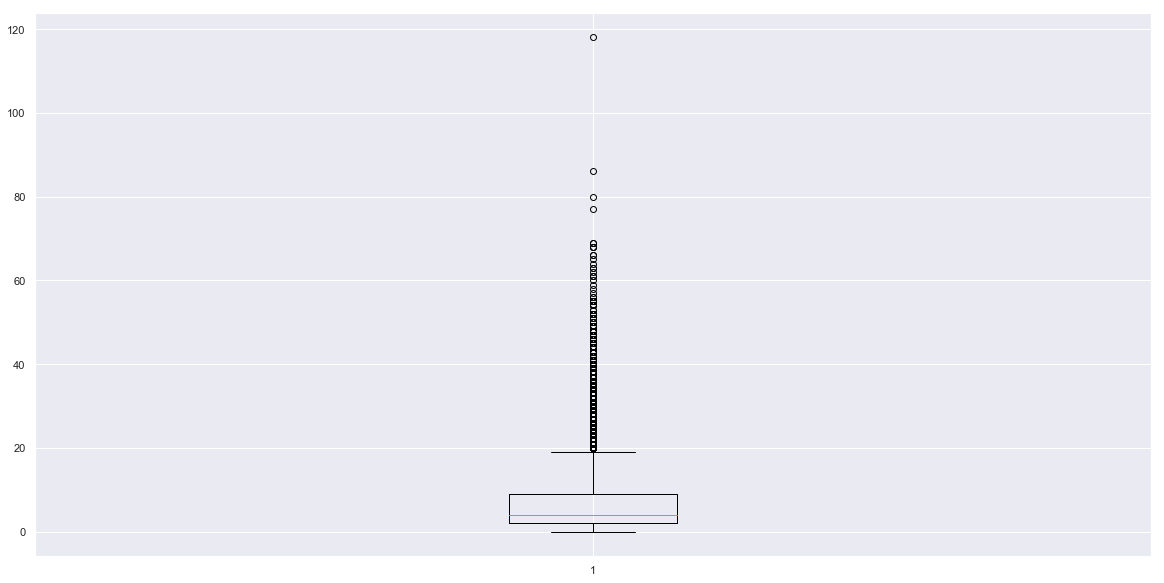

In [32]:
plt.figure(figsize=(20,10))
plt.boxplot(df['target'])

In [33]:
df['target'].quantile(np.arange(0.1,1.1,0.1))

0.1      1.0
0.2      2.0
0.3      2.0
0.4      3.0
0.5      4.0
0.6      6.0
0.7      8.0
0.8     10.0
0.9     13.0
1.0    118.0
Name: target, dtype: float64

In [34]:
df['target'].quantile(np.arange(0.9,1.01,0.01))

0.90     13.0
0.91     14.0
0.92     14.0
0.93     15.0
0.94     15.0
0.95     16.0
0.96     17.0
0.97     18.0
0.98     20.0
0.99     22.0
1.00    118.0
Name: target, dtype: float64

los target con un valor  menor que 22 ocupan el 99 por ciento de los datos. Los valores mayores a este valor deberiamos quitarlos ya que nos son representativos, los consideramos outliers.

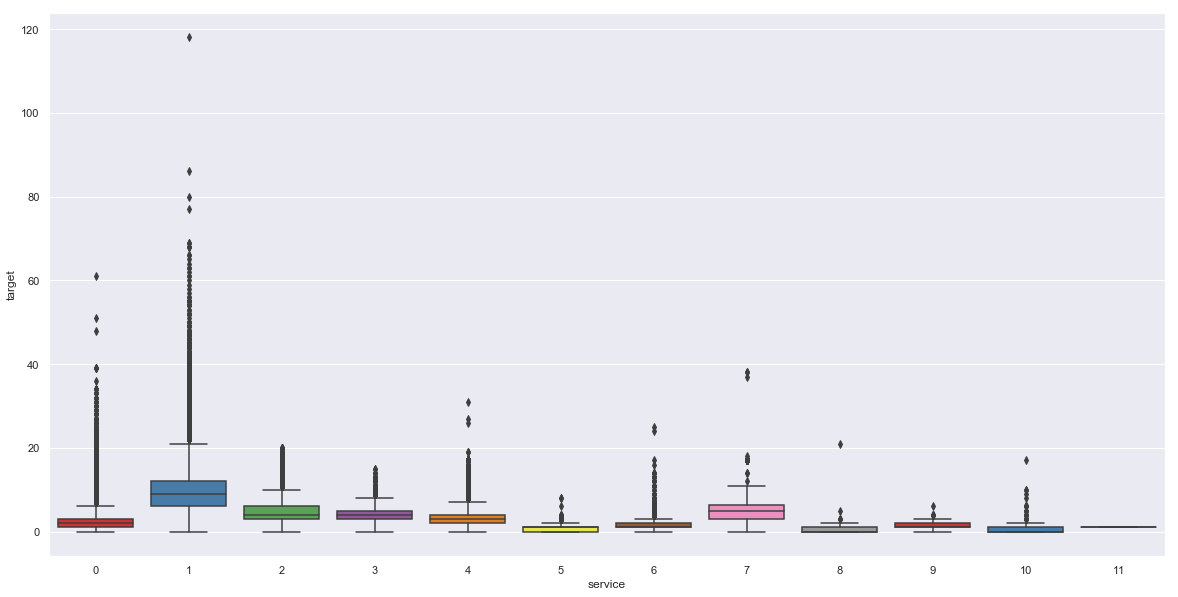

In [35]:
plt.figure(figsize=(20, 10))
sb.set(rc={'figure.figsize':(10.5,8.5)})
sb.boxplot(x=df['service'], y=df['target'], data=df, palette="Set1")

Con esto vemos los outliers por servicio. El mismo análisis se puede realizar para el resto de los features numéricos.

6- ¿Las fechas tienen sentido? Dar detalles.

Los datos de fecha originalmente no son reconocidos como datetime, son tipo object,
para utilizar todas las funcionalidades que probee el tipo np.datetime64 , se debe cargar el dataframe
de la siguiente manera:

In [36]:
df = pd.read_csv(data_path, usecols=cols, parse_dates=["date_created", "date_sent", "date_visit"])

In [37]:
df.describe(include=['object', 'datetime64'])

,sender_state,receiver_state,shipment_type,status,date_created,date_sent,date_visit
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000
unique,27,27,3,4,163,92912,68917
top,SP,SP,standard,done,2019-03-05 00:00:00,2019-02-25 16:08:00,2019-03-26 22:00:00
freq,728222,351058,593467,990460,40887,252,592
first,NaN,NaN,NaN,NaN,2018-09-26 00:00:00,2018-10-01 16:55:00,2019-02-28 00:03:00
last,NaN,NaN,NaN,NaN,2019-06-28 00:00:00,2019-03-29 07:06:00,2019-03-29 23:31:00


Ahora si, los datos date son de tipo datetime64

In [38]:
df.dtypes

sender_state                object
sender_zipcode               int64
receiver_state              object
receiver_zipcode             int64
shipment_type               object
quantity                     int64
service                      int64
status                      object
date_created        datetime64[ns]
date_sent           datetime64[ns]
date_visit          datetime64[ns]
target                       int64
dtype: object

7- ¿Que otras verificaciones básicas podrías hacer?

Se pueden continuar realizando las mismas validaciones(que los datos pertenezcan a su rango de valores), análisis de outliers, etc, para el resto de los features numéricos. para los features categóricos.

a-¿Como se podría imputar las fechas faltantes de la columna ​ date_sent​ ? Justificarlo e
implementar alguna solución.

In [39]:
df[df['date_sent'].isna()]

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target


In [40]:
df[df['date_sent'].isnull()]

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target


No hay datos faltantes, de echo ya lo habíamos verficado anteriormente, igualmente existen varios metodos para imputar datos
En el caso de las fechas, si existiesen datos faltantes, se podría utilizar el siguiente método:

    * Generar hash numérico a partir del primary key compuesto por los cuatro atributos mencionados anteriormente.
    * Transformar todas las fechas a algun formato numérico como epoch.
    * Ordenar los datos segun el nuevo hash numérico.
    * Usar algun metodo de regresion (como linear regression) para predecir nuevos valores de fechas numéricos, para las fechas faltantes, tomando como datos de entrada los hash numéricos.
    * volver a convertir todos las fechas en formato numérico a datetime.


b-¿Qué riesgos existen al imputar datos? ¿Qué riesgos existen al imputar estos en particular?
¿Cómo corregirías las fechas inconsistentes? Implementar alguna solución

El riesgo principal es que el dato generado afecte en alguna medida los mediciones u analisis sobre el dataset original, por ejemplo generando sesgos. 

c-¿Es conveniente aplicar normalización o estandarización sobre algunos features? ¿Cuales
features? ¿Porqué?

Solo se pueden normalizar features numéricos. La normalización es util cuando se desea comparar u obtener metricas de series de datos que originalmente estan defindidos en distintos rangos de valores. Normalizando se logra tener la misma escala de valores.

d-¿Qué técnica utilizarías? Implementar alguna solución.

Existen varias formas de normalizar un rngo de valores, aunque la mas conocida es la normalización standar:

$$z = \frac{X - \mu}{ \sigma}$$

e-¿Es necesario reducir la dimensión de los features?

f-¿Sería útil aplicar el algoritmo de PCA? ¿Sobre qué features? ¿Con qué objetivo?

g-Actualmente el target tiene granularidad de días, ¿lo podrías refinar? ¿Como? ¿Qué
beneficios obtendrías al aumentar la granularidad?